# Amazon SageMaker with XGBoost and Hyperparameter Tuning for Direct Marketing predictions 
_**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**_

---

---

## Contents

1. [Objective](#Objective)
1. [Background](#Background)
1. [Environment Prepration](#Environment-preparation)
1. [Data Downloading](#Data-downloading-and-exploration)
1. [Data Transformation](#Data-Transformation)
1. [SageMaker: Training](#Training)
1. [SageMaker: Deploying and evaluating model](#Deploying-and-evaluating-model)
1. [SageMaker: Hyperparameter Optimization (HPO)](#Hyperparameter-Optimization-(HPO))
1. [Conclusions](#Conclusions)


---

## Objective
The goal of this workshop is to serve as a **Minimum Viable Example about SageMaker**, teaching you how to do a **basic ML training** and **Hyper-Parameter Optimization (HPO)** in AWS. Teaching an in-depth Data Science approach is out of the scope of this workshop. We hope that you can use it as a starting point and modify it according to your future projects. 

---

## Background (problem description and approach)

- **Direct marketing**: contacting potential new customers via mail, email, phone call etc. 
- **Challenge**: A) too many potential customers. B) limited resources of the approacher (time, money etc.).
- **Problem: Which are the potential customers with the higher chance of becoming actual customers**? (so as to focus the effort only on them). 
- **Our setting**: A bank who wants to predict *whether a customer will enroll for a term deposit, after one or more phone calls*.
- **Our approach**: Build a ML model to do this prediction, from readily available information e.g. demographics, past interactions etc. (features).
- **Our tools**: We will be using the **XGBoost** algorithm in AWS **SageMaker**, followed by **Hyperparameter Optimization (HPO)** to produce the best model.



---

## Environment preparation

SageMaker requires some minimal setup at the begining. This setup is standard and you can use it for any of your future projects.  
Things to specify:
- The **S3 bucket** and **prefix** that you want to use for training and model data. **This should be within the same region as SageMaker training**!
- The **IAM role** used to give training access to your data. See SageMaker documentation for how to create these.

In [37]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import time
import os 

# setting up SageMaker parameters
import sagemaker
import boto3

sgmk_region = boto3.Session().region_name    
sgmk_client = boto3.Session().client('sagemaker')
sgmk_role = sagemaker.get_execution_role()
sgmk_bucket = sagemaker.Session().default_bucket()
sgmk_prefix = 'sagemaker/DEMO-hpo-xgboost-dm'

---

## Data downloading and exploration
Let's start by downloading the [direct marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) from UCI's ML Repository.  
We can run shell commands from Jupyter using the following code:

In [2]:
# (Running shell commands from Jupyter)
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2020-03-01 05:42:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘bank-additional.zip’ not modified on server. Omitting download.

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


Now lets read this into a Pandas data frame and take a look.

In [3]:
df_data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')

# Change Pandas presets for better visualization
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 50)         # Keep the output on one page

df_data  # show the dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


_**Specifics on each of the features:**_

*Demographics:*
* `age`: Customer's age (numeric)
* `job`: Type of job (categorical: 'admin.', 'services', ...)
* `marital`: Marital status (categorical: 'married', 'single', ...)
* `education`: Level of education (categorical: 'basic.4y', 'high.school', ...)

*Past customer events:*
* `default`: Has credit in default? (categorical: 'no', 'unknown', ...)
* `housing`: Has housing loan? (categorical: 'no', 'yes', ...)
* `loan`: Has personal loan? (categorical: 'no', 'yes', ...)

*Past direct marketing contacts:*
* `contact`: Contact communication type (categorical: 'cellular', 'telephone', ...)
* `month`: Last contact month of year (categorical: 'may', 'nov', ...)
* `day_of_week`: Last contact day of the week (categorical: 'mon', 'fri', ...)
* `duration`: Last contact duration, in seconds (numeric). Important note: If duration = 0 then `y` = 'no'.
 
*Campaign information:*
* `campaign`: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
* `pdays`: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
* `previous`: Number of contacts performed before this campaign and for this client (numeric)
* `poutcome`: Outcome of the previous marketing campaign (categorical: 'nonexistent','success', ...)

*External environment factors:*
* `emp.var.rate`: Employment variation rate - quarterly indicator (numeric)
* `cons.price.idx`: Consumer price index - monthly indicator (numeric)
* `cons.conf.idx`: Consumer confidence index - monthly indicator (numeric)
* `euribor3m`: Euribor 3 month rate - daily indicator (numeric)
* `nr.employed`: Number of employees - quarterly indicator (numeric)

*Target variable* **(the one we want to eventually predict):**
* `y`: Has the client subscribed to a term deposit? (binary: 'yes','no')

## Data Transformation
Cleaning up data is part of nearly every ML project. Several common steps include:

* **Handling missing values**: In our case there are no missing values.
* **Handling weird/outlier values**: There are some values in the dataset that may require manipulation.
* **Converting categorical to numeric**: There are a lot of categorical variables in our dataset. We need to address this.
* **Oddly distributed data**: We will be using XGBoost, which is a non-linear method, and is minimally affected by the data distribution.
* **Remove unnecessary data**: There are lots of columns representing general economic features that may not be available during inference time.

To summarise, we need to A) address some weird values, B) convert the categorical to numeric valriables and C) Remove unnecessary data:

1. Many records have the value of "999" for `pdays`. It is very likely to be a 'magic' number to represent that *no contact was made before*. Considering that, we will create a new column called "no_previous_contact", then grant it value of "1" when pdays is 999 and "0" otherwise.

2. In the `job` column, there are more than one categories for people who don't work e.g., "student", "retired", and "unemployed". It is very likely the decision to enroll or not to a term deposit depends a lot on whether the customer is working or not. A such, we generate a new column to show whether the customer is working based on `job` column.

3. We will remove the economic features and `duration` from our data as they would need to be forecasted with high precision to be used as features during inference time.

4. We convert categorical variables to numeric using *one hot encoding*.

In [4]:
df_data['no_previous_contact'] = np.where(df_data['pdays'] == 999, 1, 0)  # Indicator variable to capture when pdays takes a value of 999
df_data['not_working'] = np.where(np.in1d(df_data['job'], ['student', 'retired', 'unemployed']), 1, 0)  # Indicator for individuals not actively employed
df_model_data = df_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)  # remove unnecessary data
df_model_data = pd.get_dummies(df_model_data)  # Convert categorical variables to sets of indicators

df_model_data  # show the new transformed dataframe (which will be used for training)

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
5,45,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
6,59,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
7,41,1,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
8,24,1,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0
9,25,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


## Training

Before initializing training, there are some things that need to be done:
1. Suffle and split dataset. 
2. Convert the dataset to the right format the SageMaker algorithm expects (e.g. CSV).
3. Copy the dataset to S3 in order to be accessed by SageMaker during training. 
4. Create s3_inputs that our training function can use as a pointer to the files in S3.
5. Specify the ECR container location for SageMaker's implementation of XGBoost.

We will shuffle and split the dataset into **Training (70%)**, **Validation (20%)**, and **Test (10%)**. We will use the Training and Validation splits during the training phase, while the 'holdout' Test split will be used to evaluate the model performance after it is deployed to production.  

Amazon SageMaker's XGBoost algorithm expects data in the **libSVM** or **CSV** format with the following specifications:
- The first column must be the target variable.
- No headers should be included.

In [53]:
# shuffling and splitting dataset
train_data, validation_data, test_data = np.split(df_model_data.sample(frac=1, random_state=1729), [int(0.7 * len(df_model_data)), int(0.9*len(df_model_data))]) 

# creating CSV files for Train / Validation / Test
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)
pd.concat([test_data['y_yes'], test_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('test.csv', index=False, header=False)

# copying CSV files to S3 for SageMaker training
boto3.Session().resource('s3').Bucket(sgmk_bucket).Object(os.path.join(sgmk_prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(sgmk_bucket).Object(os.path.join(sgmk_prefix, 'validation/validation.csv')).upload_file('validation.csv')

# creating s3_inputs
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(sgmk_bucket, sgmk_prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(sgmk_bucket, sgmk_prefix), content_type='csv')

# specifying container
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sgmk_region, 'xgboost', repo_version='latest')

	get_image_uri(region, 'xgboost', '0.90-1').


Training with SageMaker follows the same usual steps with other ML libraries (e.g. SciKit-Learn):
1. Initiate a Sagemaker session.
2. Instantiate an XGBoost estimator object.
3. Define its hyperparameters.
4. Start the training job.

#### A small competition!
SageMaker's XGBoost includes 38 parameters. You can find more information about them [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html).
For simplicity, we choose to experiment only with 6 of them.

**Please select values for the 6 hyperparameters (by replacing the ?) based on the provided ranges. Later we will see which model performed best and compare it with the ones from the Hyperparameter Optimization step.**

In [6]:
sess = sagemaker.Session()  # initiate a SageMaker session

# instantiate an XGBoost estimator object
xgb = sagemaker.estimator.Estimator(training_image,  # XGBoost algorithm container
                                    sgmk_role,  #IAM role to be used
                                    train_instance_type='ml.m4.xlarge',  # type of training instance
                                    train_instance_count=1,  # number of instances to be used
                                    output_path='s3://{}/{}/output'.format(sgmk_bucket, sgmk_prefix),  # S3 location for output data
                                    sagemaker_session=sess)

# define its hyperparameters
xgb.set_hyperparameters(max_depth=?,         # [1,10]
                        eta=?,               # [0,1]
                        gamma=?,             # [0,100]
                        min_child_weight=?,  # [0,100]
                        subsample=?,         # [0,1]
                        num_round=?,         # [1,300]
                        silent=0,
                        objective='binary:logistic')


xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})  # start a training (fitting) job

2020-03-01 05:43:02 Starting - Starting the training job...
2020-03-01 05:43:03 Starting - Launching requested ML instances......
2020-03-01 05:44:10 Starting - Preparing the instances for training...
2020-03-01 05:45:02 Downloading - Downloading input data......
2020-03-01 05:46:01 Training - Training image download completed. Training in progress.
2020-03-01 05:46:01 Uploading - Uploading generated training modelArguments: train
[2020-03-01:05:45:56:INFO] Running standalone xgboost training.
[2020-03-01:05:45:56:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8513.47mb
[2020-03-01:05:45:56:INFO] Determined delimiter of CSV input is ','
[05:45:56] S3DistributionType set as FullyReplicated
[05:45:56] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-01:05:45:56:INFO] Determined delimiter of CSV input is ','
[05:45:56] S3DistributionType set as FullyReplicated
[05:45:56] 8

## Deploying and evaluating model

### Deployment
Now that we've trained the xgboost algorithm on our data, deploying the model (hosting it behind a real-time endpoint) is just one line of code!

*Attention! This may take up to 10 minutes, depending on the AWS instance you select*.

In [7]:
# xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!

### Evaluation

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy a array in memory of our notebook instance. To send it in an HTTP POST request, we will serialize it as a CSV string and then decode the resulting CSV.  
Note: For inference with CSV format, SageMaker XGBoost requires that the data **does NOT include the target variable.**

Now, we'll use a simple `predict()` function to:
- Loop over our test dataset
- Split it into mini-batches of rows
- Convert those mini-batches to CSV string payloads (notice, we drop the target variable from our dataset first)
- Retrieve mini-batch predictions by invoking the XGBoost endpoint
- Collect predictions and convert from the CSV output our model provides into a NumPy array

In [49]:
# Converting strings for HTTP POST requests on inference
from sagemaker.predictor import csv_serializer

def predict_from_endpoint(predictor, data):
    # predictor settings
    predictor.content_type = 'text/csv'
    predictor.serializer = csv_serializer
    
    predictions = ''
    predictions = ','.join([predictions, predictor.predict(data).decode('utf-8')])  # convert to CSV for inference
    
    return np.fromstring(predictions[1:], sep=',')  # convert back to numpy 


# getting the predicted probabilities 
predictions = predict_from_endpoint(xgb_predictor, test_data.drop(['y_no', 'y_yes'], axis=1).values)

print(predictions)

[0.04354563 0.11124294 0.17633459 ... 0.0573156  0.02460817 0.03605176]


These numbers are the **predicted probabilities** (in the interval [0,1]) of a potential customer enrolling for a term deposit. 
- 0: the person WILL NOT enroll.
- 1: the person WILL enroll (which makes him/her good candidate for direct marketing).

Now we will generate a **comprehensive model report**, using the following functions. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics


# Function to plot a nice comfusion matrix
def plot_confusion_matrix(confusion_matrix, 
                          class_names_list=['Class1', 'Class2'],
                          axis=None,
                          title='Confusion matrix',
                          plot_style='ggplot',
                          colormap=plt.cm.Blues):

    if axis is None:  # for standalone plot
        plt.figure()
        ax = plt.gca()
    else:  # for plots inside a subplot
        ax = axis
 
    plt.style.use(plot_style)
    
    # normalizing matrix to [0,100%]
    confusion_matrix_norm = (confusion_matrix.astype('float') / 
                             confusion_matrix.sum(axis=1)[:, np.newaxis])
    confusion_matrix_norm = np.round(100 * confusion_matrix_norm, 2)

    ax.imshow(confusion_matrix_norm,
               interpolation='nearest',
               cmap=colormap,
               vmin=0,  # to make sure colors are scaled between [0,100%]
               vmax=100)
 
    ax.set_title(title)
    tick_marks = np.arange(len(class_names_list))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names_list, rotation=0)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names_list)
    
    for i, j in itertools.product(range(confusion_matrix.shape[0]), 
                                  range(confusion_matrix.shape[1])):
        ax.text(j, i, 
                 str(confusion_matrix[i, j])+'\n('+str(confusion_matrix_norm[i,j])+'%)',
                 horizontalalignment="center",
                 color="white" if confusion_matrix_norm[i, j] > 50 else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.grid(False)
    
    if axis is None:  # for standalone plots
        plt.tight_layout()
        plt.show()


# Function to plot a nice preceision/recall curve for a binary classification model
def plot_precision_recall_curve(y_real,
                                y_predict,
                                axis=None,
                                plot_style='ggplot'):
    
    if axis is None:  # for standalone plot
        plt.figure()
        ax = plt.gca()
    else:  # for plots inside a subplot
        ax = axis

    plt.style.use(plot_style)
    
    metrics_P, metrics_R, _ = metrics.precision_recall_curve(y_real, y_predict)
    metrics_AP = metrics.average_precision_score(y_real, y_predict)
    
    ax.set_aspect(aspect=0.95)
    ax.step(metrics_R, metrics_P, color='b', where='post', linewidth=0.7)
    ax.fill_between(metrics_R, metrics_P, step='post', alpha=0.2, color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.05])
    ax.set_title('Precision-Recall curve: AP={0:0.3f}'.format(metrics_AP))
    
    if axis is None:  # for standalone plots
        plt.tight_layout()
        plt.show()


# Function to plot a nice ROC curve for a binary classification model
def plot_roc_curve(y_real,
                   y_predict,
                   axis=None,
                   plot_style='ggplot'):
    
    if axis is None:  # for standalone plot
        plt.figure()
        ax = plt.gca()
    else:  # for plots inside a subplot
        ax = axis
    
    plt.style.use(plot_style)
    
    metrics_FPR, metrics_TPR, _ = metrics.roc_curve(y_real, y_predict)
    metrics_AUC = metrics.roc_auc_score(y_real, y_predict)
    
    ax.set_aspect(aspect=0.95)
    ax.plot(metrics_FPR,
             metrics_TPR,
             color='b',
             linewidth=0.7)
    
    ax.fill_between(metrics_FPR,
                     metrics_TPR,
                     step='post',
                     alpha=0.2,
                     color='b')
    
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve: AUC={0:0.3f}'.format(metrics_AUC))
    
    if axis is None:  # for standalone plots
        plt.tight_layout()
        plt.show()


# Function to plot text inside an image
def plot_text(text, axis=None):

    if axis is None:  # for standalone plot
        plt.figure()
        ax = plt.gca()
    else:  # for plots inside a subplot
        ax = axis
        
    # set background white
    ax.set_axis_off()
    ax.set_frame_on(True)
    ax.grid(False)
    
    ax.text(x=0.8,
            y=0, 
            s=text,
            horizontalalignment="right",
            color="black")


# Function to generate a complete classification report
def generate_classification_report(y_real, 
                                   y_predict_proba, 
                                   decision_threshold=0.5, 
                                   class_names_list=None,
                                   title='Model report',
                                   plot_style='ggplot'):
    
    plt.style.use(plot_style)
    
    if class_names_list is None:
        class_names_list = ['Class 0', 'Class 1']
    
    # find out how many classes we have in the test set
    number_of_classes = len(np.unique(y_real))

    ml_report = 'Number of classes: ' + str(number_of_classes) + '\n'
    
    for i,class_name in enumerate(class_names_list):
        ml_report += str(i) + ': ' + str(class_name) + '\n'
        
    ml_report += '\nDecision threshold: ' + str(decision_threshold) + '\n'

    ml_report += '\n---------------------Performance--------------------\n\n'

    y_decision = y_predict_proba.copy()
    y_decision[y_decision>decision_threshold] = 1
    y_decision[y_decision<1] = 0
    y_decision = y_decision.astype(bool)

    # get initial classification report and more text in it
    metrics_report = metrics.classification_report(y_real, y_decision)
    metrics_ACC = metrics.accuracy_score(y_real, y_decision)
    metrics_report += ('\n Total accuracy = ' + 
                       str(round(metrics_ACC*100,2)) + '%')
    ml_report += metrics_report
    ml_report += '\n\n\n\n\n'

    # generate graphs
    fig, ax = plt.subplots(2, 2, figsize=(12,9))
    plot_text(ml_report, axis=ax[0,0])
    plot_confusion_matrix(metrics.confusion_matrix(y_real, y_decision),
                          class_names_list=class_names_list, axis=ax[0,1])
    plot_precision_recall_curve(y_real, y_predict_proba, axis=ax[1,0])
    plot_roc_curve(y_real, y_predict_proba, axis=ax[1,1])
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()

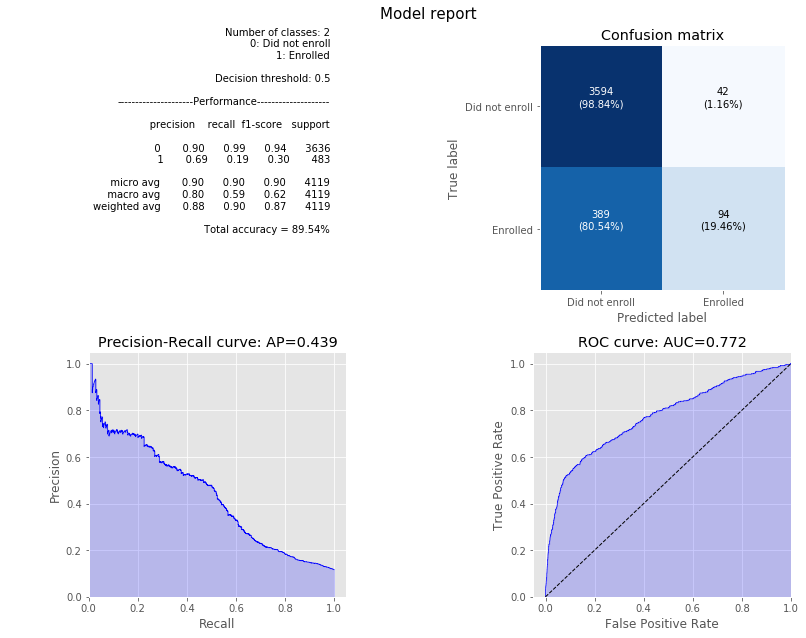

In [10]:
generate_classification_report(y_real=test_data['y_yes'].values, 
                               y_predict_proba=predictions, 
                               decision_threshold=0.5,
                               class_names_list=['Did not enroll','Enrolled'],
                               title='Initial model')

---

## Hyperparameter Optimization (HPO)
*Note, with the default setting below, the hyperparameter tuning job can take up to 30 minutes to complete.*

We will use SageMaker HyperParameter Optimization (HPO) to automate the searching process effectively. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.  

We will tune 4 hyperparameters in this example:
* **eta**: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative. 
* **alpha**: L1 regularization term on weights. Increasing this value makes models more conservative. 
* **min_child_weight**: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is. 
* **max_depth**: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted. 

SageMaker hyperparameter tuning will automatically launch **multiple training jobs** with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will specify the maximum number of HPO tries (`max_jobs`) and how many of these can happen in parallel (`max_parallel_jobs`).

Tip: `max_parallel_jobs` creates a **trade-off between parformance and speed** (better hyperparameter values vs how long it takes to find these values). If `max_parallel_jobs` is large, then HPO is faster, but the discovered values may not be optimal. Smaller `max_parallel_jobs` will increase the chance of finding optimal values, but HPO will take more time to finish.

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: **validation:auc** and **train:auc**, and we elected to monitor *validation:auc* as you can see below. In this case, we only need to specify the metric name and do not need to provide regex.  

If you bring your own algorithm, your algorithm emits metrics by itself. In that case, you'll need to add a MetricDefinition object here to define the format of those metrics through regex, so that SageMaker knows how to extract those metrics from your CloudWatch logs.

For more information on the documentation of the Sagemaker HPO please refer [here](https://sagemaker.readthedocs.io/en/stable/tuner.html).

In [11]:
# import required HPO objects
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# setting up hyperparameter ranges
hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

# setting up the objective metric
objective_metric_name = 'validation:auc'

# instantiate a HPO object
tuner = HyperparameterTuner(xgb,                        # the SageMaker estimator object
                            objective_metric_name,      # the objective metric to be used for HPO
                            hyperparameter_ranges,      # the range of hyperparameters
                            max_jobs=20,                # total number of HPO jobs
                            max_parallel_jobs=3,        # how many HPO jobs can run in parallel
                            strategy='Bayesian',        # the internal optimization strategy of HPO
                            objective_type='Maximize')  # maximize or minimize the objective metric   

### Launch HPO
Now we can launch a hyperparameter tuning job by calling *fit()* function. After the hyperparameter tuning job is created, we can go to SageMaker console to track the progress of the hyperparameter tuning job until it is completed.

In [12]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(sgmk_bucket, sgmk_prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(sgmk_bucket, sgmk_prefix), content_type='csv')

# start HPO
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

# wait, until HPO is finished
hpo_state = 'InProgress'
while hpo_state == 'InProgress':
    hpo_state = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
                        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
time.sleep(10)  # wait for 10 sec to make sure the job object is available in AWS

print('HPO finished!')

### Deploy and test optimized model
Deploying the best model is simply one line of code:

In [18]:
best_model_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

2020-03-01 06:15:53 Starting - Preparing the instances for training
2020-03-01 06:15:53 Downloading - Downloading input data
2020-03-01 06:15:53 Training - Training image download completed. Training in progress.
2020-03-01 06:15:53 Uploading - Uploading generated training model
2020-03-01 06:15:53 Completed - Training job completedArguments: train
[2020-03-01:06:15:39:INFO] Running standalone xgboost training.
[2020-03-01:06:15:39:INFO] Setting up HPO optimized metric to be : auc
[2020-03-01:06:15:39:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8501.6mb
[2020-03-01:06:15:39:INFO] Determined delimiter of CSV input is ','
[06:15:39] S3DistributionType set as FullyReplicated
[06:15:39] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-01:06:15:39:INFO] Determined delimiter of CSV input is ','
[06:15:39] S3DistributionType set as FullyReplicated
[06:15:39] 8238x59 matrix 

[0.05456186 0.09523866 0.16532272 ... 0.0380405  0.03337976 0.04507932]


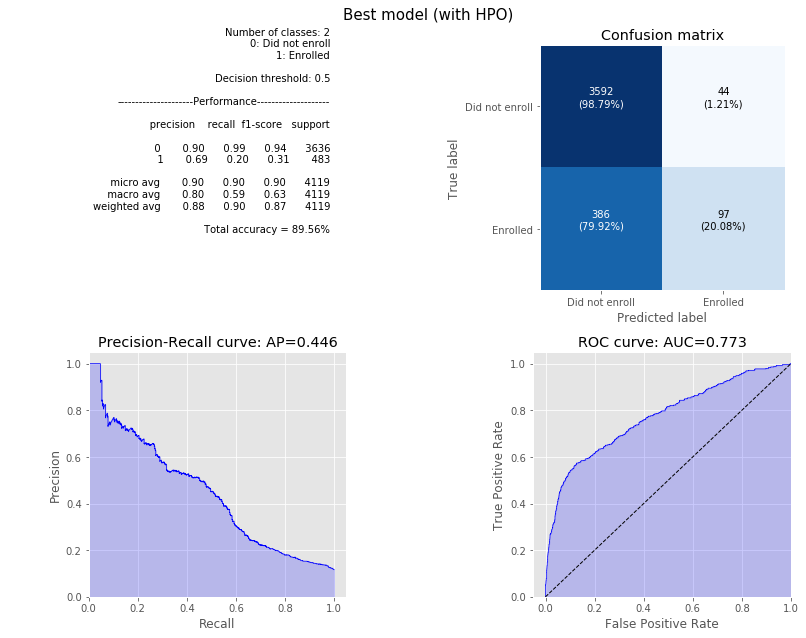

In [52]:
# getting the predicted probabilities of the best model
predictions = predict_from_endpoint(best_model_predictor, test_data.drop(['y_no', 'y_yes'], axis=1).values)

print(predictions)

# generate report for the best model
generate_classification_report(y_real=test_data['y_yes'].values, 
                               y_predict_proba=predictions, 
                               decision_threshold=0.5,
                               class_names_list=['Did not enroll','Enrolled'],
                               title='Best model (with HPO)')

## Conclusions

The optimized HPO model exhibits AUC=0.773  
Depending on the number of tries, HPO can give a better performing model, compared to simply trying different hyperparameters (by trial and error). 